In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
stations = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)

In [10]:
columns = inspector.get_columns('')

engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Precipitation Analysis

In [63]:
# Find the most recent date in the data set.

session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01')

<AxesSubplot:xlabel='date'>

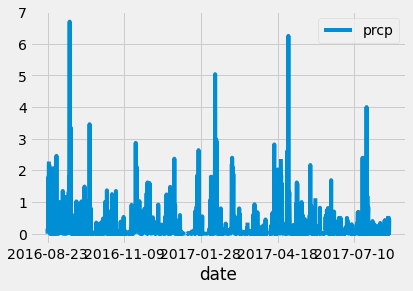

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_tuple = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent = most_recent_tuple[0]
#most_recent = dt.datetime.strptime(most_recent_tuple[0], '%y-%m-%d')
#most_recent = most_recent[0].replace("-", "")                           #I've tried a ton of ways to convert the data string to a date, but nothing worked. 
#format_str = '%y%m%d'
#most_recent = dt.datetime.strptime(most_recent, format_str)

# Calculate the date one year from the last date in data set.
year_prior = '2016-08-23'

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_prior).\
    order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip_data, columns =['date', 'prcp']).set_index('date')

# Sort the dataframe by date
df.sort_index
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()



In [54]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [72]:
# Design a query to calculate the total number stations in the dataset
print (f'The total number of stations in the dataset is: {session.execute(session.query(measurement.station).statement.with_only_columns([func.count()]).order_by(None)).scalar()}')     


The total number of stations in the dataset is: 19550


In [78]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
#session.query(measurement.station, func.count(measurement.date)).group_by(measurement.station).all()

session.query(measurement.station, func.count(measurement.date)).group_by(measurement.station).order_by(func.count(measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [93]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
print (f'The lowest temp for USC00519281 is: {session.query(func.min(measurement.tobs)).filter(measurement.station=="USC00519281").scalar()}')
print (f'The highest temp for USC00519281 is: {session.query(func.max(measurement.tobs)).filter(measurement.station=="USC00519281").scalar()}')
print (f'The average temp for USC00519281 is: {session.query(func.avg(measurement.tobs)).filter(measurement.station=="USC00519281").scalar()}')


The lowest temp for USC00519281 is: 54.0
The highest temp for USC00519281 is: 85.0
The average temp for USC00519281 is: 71.66378066378067


<AxesSubplot:ylabel='Frequency'>

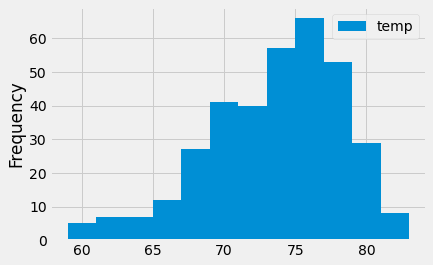

In [106]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.date, measurement.tobs).filter(measurement.station=="USC00519281").filter(measurement.date >= year_prior).all()
df_temp = pd.DataFrame(temp_data, columns =['date', 'temp']).set_index('date')

df_temp.sort_index
df_temp.plot.hist(bins=12)

# Close session

In [105]:
# Close Session
session.close()